## Import Libraries

In [10]:
import numpy as np
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (6.5, 6.5)

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

# plotting style
plt.style.use('classic')
plt.style.use('dark_background')
#plt.style.use('bmh')

import seaborn as sns

from IPython.display import Image

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

import warnings
warnings.filterwarnings('ignore');

## Python Implementation

**Algorithm Outline**: <br>
Input - X , matrix with N observations in D dimensions <br>
Output - Y, matrix with N observations in d << D dimensions <br>
Parameter(s) = k, number of nearest neighbors to consider <br>
1. Find nearest neighbors for each $X_i$ in X <br>
2. Solve for reconstruction weights W <br>
3. Compute embedding coordinates Y


In this naive implementation, the time complexity will be very slow compared to existing implementations, so I test it on only small datasets.

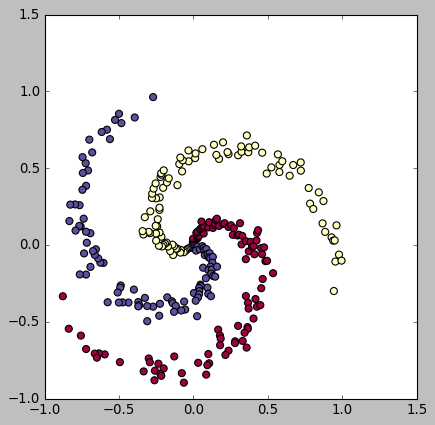

In [21]:
# spiral dataset from http://cs231n.github.io/neural-networks-case-study/
plt.style.use('classic')
plt.figure(figsize=(6,6))
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show();

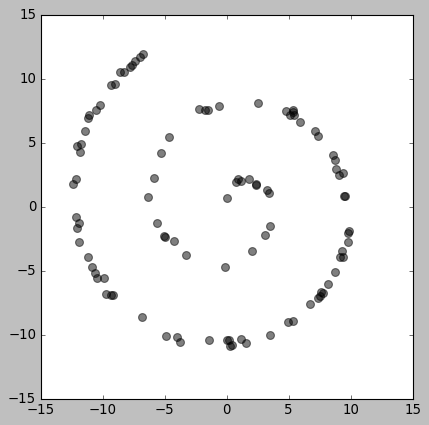

In [74]:
plt.figure(figsize=(6,6))
n = np.sqrt(np.random.rand(100,1)) * 780 * (2*np.pi)/360
d1x = -np.cos(n)*n + np.random.rand(100,1) * 0.6
d1y = np.sin(n)*n + np.random.rand(100,1) * 0.6
plt.scatter(d1x, d1y, alpha=0.5, c='black', s=50);

In [75]:
X = np.hstack((d1x,d1y))
X.shape

(100, 2)

In [76]:
def LLE(X, k, q):
    
    # Inputs: X = Data matrix with N observations in p dimensions
    # Output: Y = Lower dimensional N x q matrix (q << p)
    # k = number of nearest neighbors to consider
    # q = specified dimension for the embedding space
    
    # Find k nearest neighbors for each xi
    
    # now we set up code to solve for reconstruction weights W
    W = np.zeros((N, N))
    
    # calculate embedded coordinates

In [77]:
# compute pairwise distance matrix to find k nearest neighbors for each Xi in X
from sklearn.metrics import pairwise_distances
dist_matrix = pairwise_distances(X)
dist_matrix.shape

(100, 100)

In [111]:
# function that outputs N x k matrix with k nearest neighbors for each observation in X
def nearest_neighbors(X, k):
    # we use k+1 here since Xi will have the shortest distance to itself
    knn_matrix = np.zeros((len(X), k))
    # compute pairwise distances
    dist_matrix = pairwise_distances(X)
    # for each row find indices of k nearest neighbors
    for i in range(len(X)):
        knn_matrix[i] = dist_matrix[i,:].argsort()[1:k+1]
    return knn_matrix

In [118]:
# neighbors for a given xi (first element in X)
neighbors = nearest_neighbors(X, 5)[0] # indices of neighbors

# get actual data points for neighbors of xi
X[0]
X[neighbors.astype('int')]

# create matrix z by subtracting xi from each column (zj = xj - xi)
z = X[neighbors.astype('int')] - X[0]
z = np.matrix(z)

# compute k by k Gram Matrix
G = z * z.T
G.shape

array([-4.2081491 , -2.69840956])

array([[-4.98490506, -2.41433843],
       [-5.05306427, -2.2983778 ],
       [-3.30316424, -3.7753432 ],
       [-5.58995434, -1.26752307],
       [-6.29833938,  0.75895446]])

(5, 5)

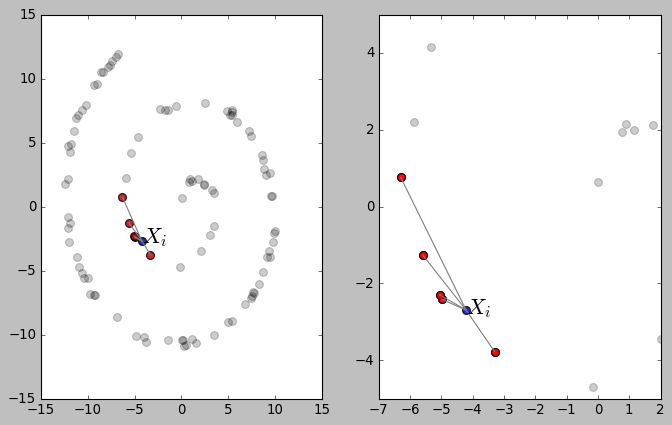

In [126]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(X[0, 0], X[0, 1], c='blue', s=50, alpha=0.8)
plt.text(X[0, 0], X[0, 1] - 0.1, s='$X_i$', size=20)
plt.scatter(X[neighbors.astype('int'), 0], X[neighbors.astype('int'), 1], c='red', alpha = 0.8, s=50)
for i in range(len(neighbors)):
    plt.plot(X[[0, neighbors.astype('int')[i]], 0], X[[0, neighbors.astype('int')[i]], 1], c='gray')
plt.scatter(X[:,0], X[:,1], alpha=0.2, c='black', s=50);

plt.subplot(1, 2, 2)
plt.scatter(X[0, 0], X[0, 1], c='blue', s=50, alpha=0.8)
plt.text(X[0, 0], X[0, 1] - 0.1, s='$X_i$', size=20)
plt.scatter(X[neighbors.astype('int'), 0], X[neighbors.astype('int'), 1], c='red', alpha = 0.8, s=50)
for i in range(len(neighbors)):
    plt.plot(X[[0, neighbors.astype('int')[i]], 0], X[[0, neighbors.astype('int')[i]], 1], c='gray')
plt.scatter(X[:,0], X[:,1], alpha=0.2, c='black', s=50);
plt.scatter(X[neighbors.astype('int'), 0], X[neighbors.astype('int'), 1], c='red', alpha = 0.8, s=50)
plt.xlim(-7,2);
plt.ylim(-5, 5);

In [170]:
# n x k matrix with each respective neighbor group as the rows
kNN = nearest_neighbors(X, 5)
dist_matrix[:,kNN[0].astype('int')].shape
X[:5]
X[kNN[2].astype('int'),:]

(100, 5)

array([[-4.2081491 , -2.69840956],
       [ 3.06297128, -2.2117273 ],
       [ 9.04985677,  2.45204749],
       [-9.92301399, -5.61145376],
       [-4.98490506, -2.41433843]])

array([[9.37865254, 2.65174999],
       [8.80080844, 2.96681783],
       [8.72206094, 3.6255159 ],
       [8.62247439, 4.04071959],
       [9.48463739, 0.85073258]])

In [163]:
kNN.shape
dist_matrix.shape
kNN[:5]
dist_matrix[0:]
dist_matrix[kNN.astype('int')].shape;

In [172]:
X[kNN[0].astype('int'),:]
kNN.shape[1]

array([[-4.98490506, -2.41433843],
       [-5.05306427, -2.2983778 ],
       [-3.30316424, -3.7753432 ],
       [-5.58995434, -1.26752307],
       [-6.29833938,  0.75895446]])

5

In [212]:
z = np.zeros((X.shape[0], kNN.shape[1], X.shape[1]))
for i in range(len(X)):
    z[i,:] = X[kNN[i].astype('int'),:] - X[i]

In [213]:
z.shape
z[0]

(100, 5, 2)

array([[-0.77675596,  0.28407114],
       [-0.84491518,  0.40003176],
       [ 0.90498486, -1.07693363],
       [-1.38180524,  1.43088649],
       [-2.09019028,  3.45736403]])

In [223]:
weights = np.zeros((z.shape[0], z.shape[1]))

for i in range(len(X)):
    # create matrix z by subtracting xi from each column (zj = xj - xi)
    zj = np.matrix(z[i])
    # compute k by k Gram Matrix
    G = zj * zj.T
    # solve system of linear equations
    weights[i] = np.linalg.solve(G, np.array([1, 1, 1, 1, 1]))

In [227]:
G
np.linalg.solve(G, np.array([1, 1, 1, 1, 1]))
weights.shape
weights[:5]

matrix([[ 0.06461221, -0.22553185, -0.24511456, -0.41204156, -0.49183261],
        [-0.22553185,  0.96320526,  0.99640203,  1.66803995,  2.1836734 ],
        [-0.24511456,  0.99640203,  1.04255793,  1.7470129 ,  2.23945636],
        [-0.41204156,  1.66803995,  1.7470129 ,  2.9277104 ,  3.74618064],
        [-0.49183261,  2.1836734 ,  2.23945636,  3.74618064,  4.98269307]])

array([-7.16695670e+16,  2.86737895e+16, -1.29538559e+16, -2.66415234e+16,
        6.21148689e+15])

(100, 5)

array([[ 1.97053005e+16, -3.00953499e+16, -6.75525091e+16,
        -2.11415234e+16, -1.04290609e+16],
       [-2.51408106e+16, -1.27100640e+16,  7.69928710e+14,
        -3.42399861e+15,  2.93110998e+15],
       [-1.42417172e+16, -5.01012857e+16,  3.64643583e+15,
         3.33291820e+15, -1.19032623e+16],
       [-7.11936810e+14, -3.79403811e+15,  2.43108447e+15,
         2.19763619e+15, -2.03396648e+15],
       [ 2.27388137e+17, -6.12466230e+16,  2.09942780e+16,
         4.26445818e+16, -3.08939300e+15]])